In [2]:
import numpy as np
from pprint import pprint
from time import time

In [3]:
def Product(matrices):
    p = matrices[0]
    for matrix in matrices[1:]:
        p = np.kron(p,matrix) #Tensor Product!
    return p


def U(n, f):
    U = np.zeros((2**(n + 1), 2**(n + 1)))
    for input_state in range(2**(n + 1)):
        input_string = input_state >> 1
        output_qubit = (input_state & 1) ^ (f[input_string]) # remove IN, XOR with f(IN)
        output_state = (input_string << 1) + output_qubit # the full state, with new OUT
        U[input_state, output_state] = 1
    return U

        
def Initialization(n):
    state_0 = np.array([[1],[0]])
    state_1 = np.array([[0],[1]])
    H_gate = np.array([[1,1], [1,-1]])/2**0.5

    listStates = []
    listGates_H = []
    for i in range(n):
        listStates.append(state_0)
        listGates_H.append(H_gate)
    listStates.append(state_1)
    listGates_H.append(H_gate)
    return [Product(listStates), Product(listGates_H)]
    
    
def Deutsch_Jozsa(n, f):
    psi_0 , H = Initialization(n)
    psi_1 = np.dot(H, psi_0)
    psi_2 = np.dot(U(n, f), psi_1)
    psi_3 = np.dot(H, psi_2)
    if (psi_3[1] + psi_3[1])**2 > 0.5:
        print('Constant')
    else:
        print('Balanced')

In [55]:
f1 = [1,1,1,1,1,1,1,1]
f2 = [1,0,0,1,1,0,1,0]
f3 = [0,0,0,0,0,0,0,0]
f4 = [0,0,0,0,1,1,1,1]

t = time()
Deutsch_Jozsa(3,f1)
print('Time',time()-t)
# Deutsch_Jozsa(3,f2)
# Deutsch_Jozsa(3,f3)
# Deutsch_Jozsa(3,f4)

Constant
Time 0.0029337406158447266


In [37]:
tt = np.zeros(19)
for n in range(1,14):
    f1 = np.ones(2**n,dtype=bool)
    t = time()
    Deutsch_Jozsa(n,f1)
    tt[n-1] = time()-t

Constant
Constant
Constant
Constant
Constant
Constant
Constant
Constant
Constant
Constant
Constant
Constant
Constant


<BarContainer object of 14 artists>

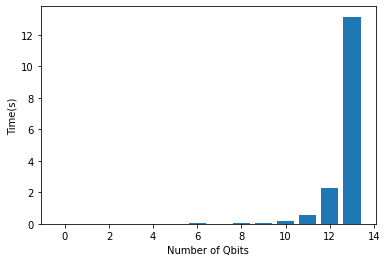

In [4]:
import matplotlib.pyplot as plt
plt.xlabel('Number of Qbits')
plt.ylabel('Time(s)')
plt.bar(list(range(14)),tt)

<img src="https://qiskit.org/textbook/ch-algorithms/images/deutsch_steps.png" />

# Qiskit

In [6]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [7]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [31]:
aer_sim = Aer.get_backend('aer_simulator')
ttq = np.zeros(19)
n = 1
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)

for n in range(1,20):
    t = time()
    oracle_gate = dj_oracle('balanced', n)
    dj_circuit = dj_algorithm(oracle_gate, n)
    transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
    qobj = assemble(transpiled_dj_circuit)
    results = aer_sim.run(qobj).result()
    answer = results.get_counts()
    ttq[n-1] = time() - t 

<BarContainer object of 19 artists>

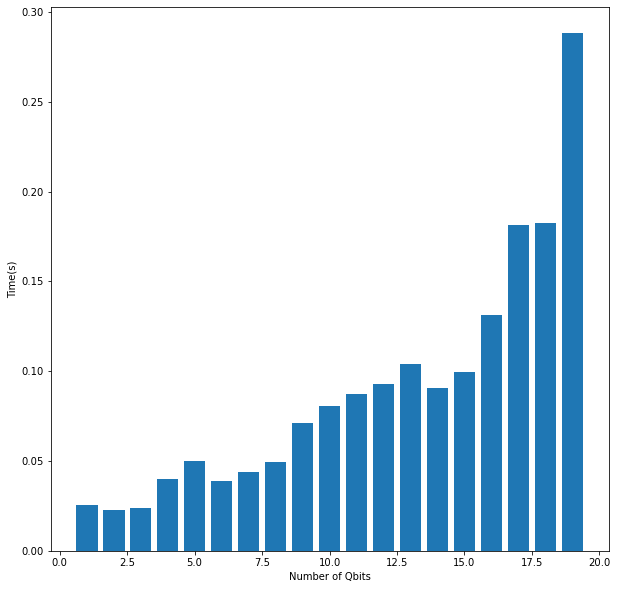

In [32]:
import matplotlib.pyplot as plt
plt.xlabel('Number of Qbits')
plt.ylabel('Time(s)')
plt.bar(list(range(1,20)),ttq)

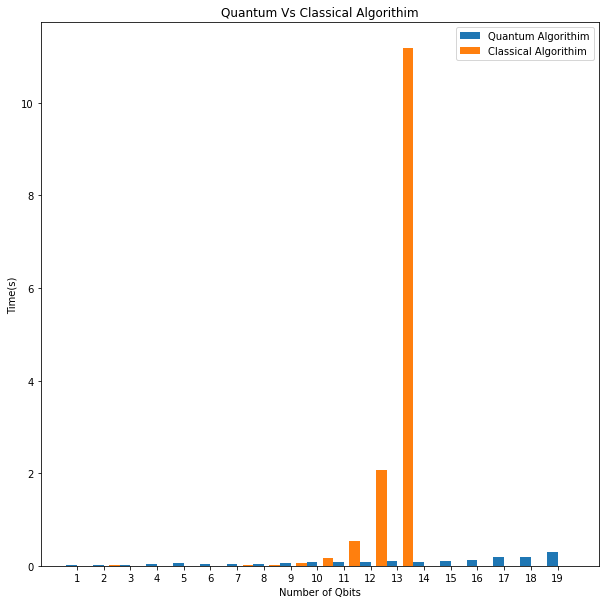

In [56]:
n = 20
x = np.arange(1,n)
plt.bar(x - 0.2 , ttq[:n-1],0.4, label = 'Quantum Algorithim')
plt.bar(x + 0.4, tt[:n-1],0.4, label = 'Classical Algorithim')
plt.xticks(x,x)
plt.xlabel("Number of Qbits")
plt.ylabel("Time(s)")
plt.title("Quantum Vs Classical Algorithim")
plt.legend()
plt.savefig('20.png')
plt.show()

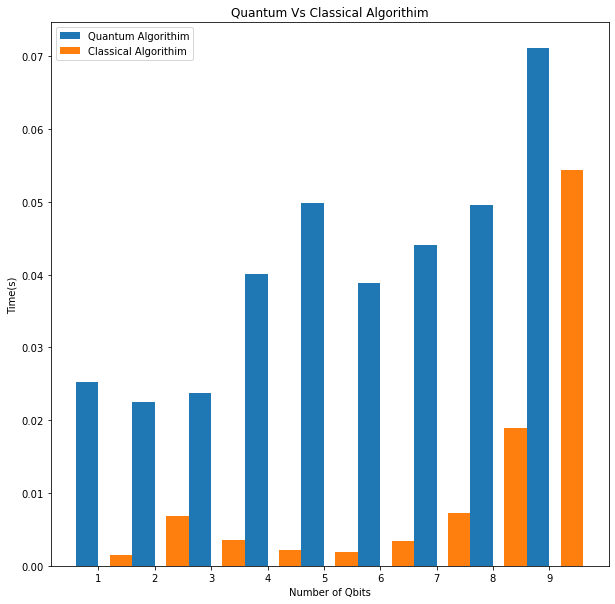

In [57]:
n = 10
x = np.arange(1,n)
plt.bar(x - 0.2 , ttq[:n-1],0.4, label = 'Quantum Algorithim')
plt.bar(x + 0.4, tt[:n-1],0.4, label = 'Classical Algorithim')
plt.xticks(x,x)
plt.xlabel("Number of Qbits")
plt.ylabel("Time(s)")
plt.title("Quantum Vs Classical Algorithim")
plt.legend()
plt.rcParams['figure.figsize'] = [10,10]
plt.savefig('10.png')
plt.show()


In [14]:
plot_histogram(answer)
dj_circuit.draw()

┌───┐     ┌──────────┐┌───┐┌─┐                                          »
 q_0: ┤ H ├─────┤0         ├┤ H ├┤M├──────────────────────────────────────────»
      ├───┤     │          │├───┤└╥┘┌─┐                                       »
 q_1: ┤ H ├─────┤1         ├┤ H ├─╫─┤M├───────────────────────────────────────»
      ├───┤     │          │├───┤ ║ └╥┘┌─┐                                    »
 q_2: ┤ H ├─────┤2         ├┤ H ├─╫──╫─┤M├────────────────────────────────────»
      ├───┤     │          │├───┤ ║  ║ └╥┘┌─┐                                 »
 q_3: ┤ H ├─────┤3         ├┤ H ├─╫──╫──╫─┤M├─────────────────────────────────»
      ├───┤     │          │├───┤ ║  ║  ║ └╥┘┌─┐                              »
 q_4: ┤ H ├─────┤4         ├┤ H ├─╫──╫──╫──╫─┤M├──────────────────────────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║ └╥┘┌─┐                           »
 q_5: ┤ H ├─────┤5         ├┤ H ├─╫──╫──╫──╫──╫─┤M├───────────────────────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║ └╥┘┌─┐                        »
 q_6: ┤ H ├─────┤6         ├┤ H ├─╫──╫──╫──╫──╫──╫─┤M├────────────────────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║ └╥┘┌─┐                     »
 q_7: ┤ H ├─────┤7         ├┤ H ├─╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  »
 q_8: ┤ H ├─────┤8         ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               »
 q_9: ┤ H ├─────┤9         ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────»
      ├───┤     │   Oracle │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐            »
q_10: ┤ H ├─────┤10        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         »
q_11: ┤ H ├─────┤11        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      »
q_12: ┤ H ├─────┤12        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   »
q_13: ┤ H ├─────┤13        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐»
q_14: ┤ H ├─────┤14        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘»
q_15: ┤ H ├─────┤15        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
q_16: ┤ H ├─────┤16        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
q_17: ┤ H ├─────┤17        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
      ├───┤     │          │├───┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
q_18: ┤ H ├─────┤18        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
      ├───┤┌───┐│          │└───┘ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
q_19: ┤ X ├┤ H ├┤19        ├──────╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
      └───┘└───┘└──────────┘      ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
 c_0: ════════════════════════════╩══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬═»
                                     ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
 c_1: ═══════════════════════════════╩══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬═»
                                        ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
 c_2: ══════════════════════════════════╩══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬═»
                                           ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
 c_3: ═════════════════════════════════════╩══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬═»
                                              ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
 c_4: ════════════════════════════════════════╩══╬══╬══╬══╬══╬══╬══╬══╬══╬══╬═»
      